In [205]:
%matplotlib inline
from umda import EmbeddingModel
from umda.compute import cosine_similarity
from joblib import load
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import h5py
from dask import array as da
from dask_ml.metrics import pairwise_distances
from rdkit import Chem
from rdkit.Chem.Descriptors import ExactMolWt, MaxAbsPartialCharge

# Unsupervised machine learning of chemical inventories

## Motivation

_We can spend whole lifetimes trying to think of what molecules fit in where and when._ Chemical intuition is great, but is not guaranteed to converge to a consistent solution.

Unsupervised machine learning provides an avenue for potentially "letting the molecules speak for themselves"

Authors: KLK Lee, J Patterson, AM Burkhardt, V Vankayalapati, MC McCarthy, BA McGuire

## Approach

We want to express any observable property, such as column density or reaction rate coefficient, as an abstract function $f(x)$ for molecule $x$. The problem can be broken down into two components:

1. Representing molecules as $x$
2. Learning a function that best approximates $f(x)$

### Representation learning

We use ideas borrowed from natural language processing to generate vector representations of molecules. A two-layer neural network learns the mapping between atom environments (determined by their nearest neighbors) and an $n$-dimensional vector. A molecule is given as the sum of its atom vectors, and bestows some properties that resemble chemical inution. For example, a direct method to quantify chemical similarity:


In [2]:
embedder = EmbeddingModel.from_pkl("../../models/mol2vec_model.pkl", transform_path="../../models/embedding_pipeline.pkl")

/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator IncrementalPCA from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.23

In [3]:
benzene_smi = "c1ccccc1"
cn_smi = "[C]#N"
phenyl_smi = "C1=CC=[C]C=C1"
benzonitrile_smi = "C1=CC=C(C=C1)C#N"
glycine_smi = "C(C(=O)O)N"
hc11n_smi = "C#CC#CC#CC#CC#CC#N"
corannulene_smi = "C1=CC2=C3C4=C1C=CC5=C4C6=C(C=C5)C=CC(=C36)C=C2"
c9h_smi = "[C]#CC#CC#CC#CC"
caa_smi = "C=C=CC#CC#N"

In [27]:
embedder.vectorize("[H]N#CC#CC#N")

array([-1.66953501e+01, -6.66635614e+00,  1.22286232e+00,  4.68560494e-01,
        1.13498072e+00, -2.15878723e+00,  3.45547369e-01, -3.42591653e-01,
        3.48881052e+00,  3.34530561e+00,  1.85347177e+00,  2.77750759e+00,
        5.88622843e+00, -3.06759972e+00, -3.23366130e+00,  1.58021105e+00,
       -4.26702395e-01,  1.22346804e+00,  1.38470659e+00,  2.38316832e-01,
       -9.50560246e-01, -6.77564114e-01,  3.26718774e-01, -1.60710255e+00,
        1.15804013e-01,  1.38251057e-03,  6.68043232e-01,  7.43261604e-02,
        1.01884269e-01, -2.01412914e-02, -4.19304101e-01,  7.63262301e-01,
       -3.87184745e-01,  7.71302796e-01,  1.03762342e-01,  1.09757055e+00,
        1.98149495e-01, -1.39337934e-01, -1.22746214e+00, -3.27369585e-02,
        7.22253394e-01, -7.12791161e-01, -8.75044452e-01, -5.53049592e-01,
        2.29659225e-01, -1.38335090e+00, -1.96943067e-01, -2.06141937e-01,
       -5.26710392e-01, -2.86295129e-02,  1.22555057e+00,  9.96156269e-01,
       -1.22128996e+00, -

In [4]:
benzene = embedder.vectorize(benzene_smi)
benzonitrile = embedder.vectorize(benzonitrile_smi)
glycine = embedder.vectorize(glycine_smi)
hc11n = embedder.vectorize(hc11n_smi)
corannulene = embedder.vectorize(corannulene_smi)
phenyl = embedder.vectorize(phenyl_smi)
cn = embedder.vectorize(cn_smi)
c9h = embedder.vectorize(c9h_smi)
caa = embedder.vectorize(caa_smi)

In [6]:
# calculate the cosine similarity between two molecules
cosine_similarity(benzene, benzonitrile)

0.9064158655622496

Benzene is closer to glycine than to HC11N

In [7]:
cosine_similarity(benzene, glycine)

0.831834049474841

In [8]:
cosine_similarity(benzene, hc11n)

0.35635339025729007

Corannulene is closer to benzene than to HC11N

In [8]:
cosine_similarity(benzene, corannulene)

0.24717840849911304

In [9]:
cosine_similarity(hc11n, corannulene)

-0.006028164223801348

Because we are working in a continuous vector representation, we can also take advantage of vector operations to do "molecular arithmetic". For example, the sum of two vectors (i.e. reactants) should put you in a space close to the desired product:

In [10]:
cosine_similarity(phenyl + cn, benzonitrile)

0.9239119487633335

Slight difference in the reaction, and we end up in a space that's close but not exactly the same as the "desired" reaction

In [11]:
cosine_similarity(benzene + cn, benzonitrile)

0.9215585964003977

Properties of the molecule, including things like aromaticity, reactivity, etc. are _implicitly_ packed into a small number of dimensions:

In [12]:
benzene.shape

(70,)

### Approximating molecular properties

Now we have our $x$, we can use off the shelf algorithms to predict properties we care about. The two we go into here are column densities (as a stand in for abundance) and reaction rate coefficients $k(T)$.

There are many ways to learn an approximation to $f(x)$, but for simplicity we worked on non-parametric algorithms as a means to obtain a baseline of what you would expect based solely on distance in latent chemical space. Basically, everything we deal with works as:

$$f(x) \approx g(x - x')$$

In other words, the properties of all molecules are evaluated based on the distance $x - x'$ from known/observed data points.

At zeroth order, we could come up with molecules to look for solely on the euclidean distance between molecules in TMC-1, and a Frankenstein dataset 3.3 million molecules I curated from various sources.

In [9]:
dataset = pd.read_pickle("../../data/processed/combined_smiles.pkl.bz2")

In [10]:
dataset.groupby("Labels").count()

,Raw,MW
Labels,,
0.0,2905663,2905663
1.0,310368,310368
2.0,409,409
3.0,59,59
4.0,16,16
5.0,2300,2300
6.0,156,156
7.0,97483,97483


| Label | Source |
|-------|--------|
| 0 | ZINC |
| 1 | QM9 |
| 2 | KIDA |
| 3 | TMC-1 |
| 4 | Random PAHs |
| 5 | NASA IR PAH |
| 6 | Yalamanchi _et al._ 2020 |
| 7 | PubChem |

We have precomputed vectors for the whole dataset, which we can just use as quick look up tables effectively

In [11]:
h5_data = h5py.File("../../data/processed/pipeline_embeddings_70.h5", "r")
vectors = da.from_array(h5_data["pca"])

In [12]:
vectors

dask.array<array, shape=(3316454, 70), dtype=float64, chunksize=(239674, 70), chunktype=numpy.ndarray>

Looking up a molecule is as simple as just calculating the distance between every entry in our database.

In [28]:
# we don't really care about the distance values, just the index
distances = pairwise_distances(vectors, embedder.vectorize("[H]N#CC#CC#N")[None,:]).ravel().compute()
sorted_indices = np.argsort(distances)
top_ten = sorted_indices[:100]

Using the indices, we can look up which molecules these are

In [29]:
mols = [
    Chem.MolFromSmiles(smi) for smi in dataset.iloc[top_ten].head(50)["Raw"]
]

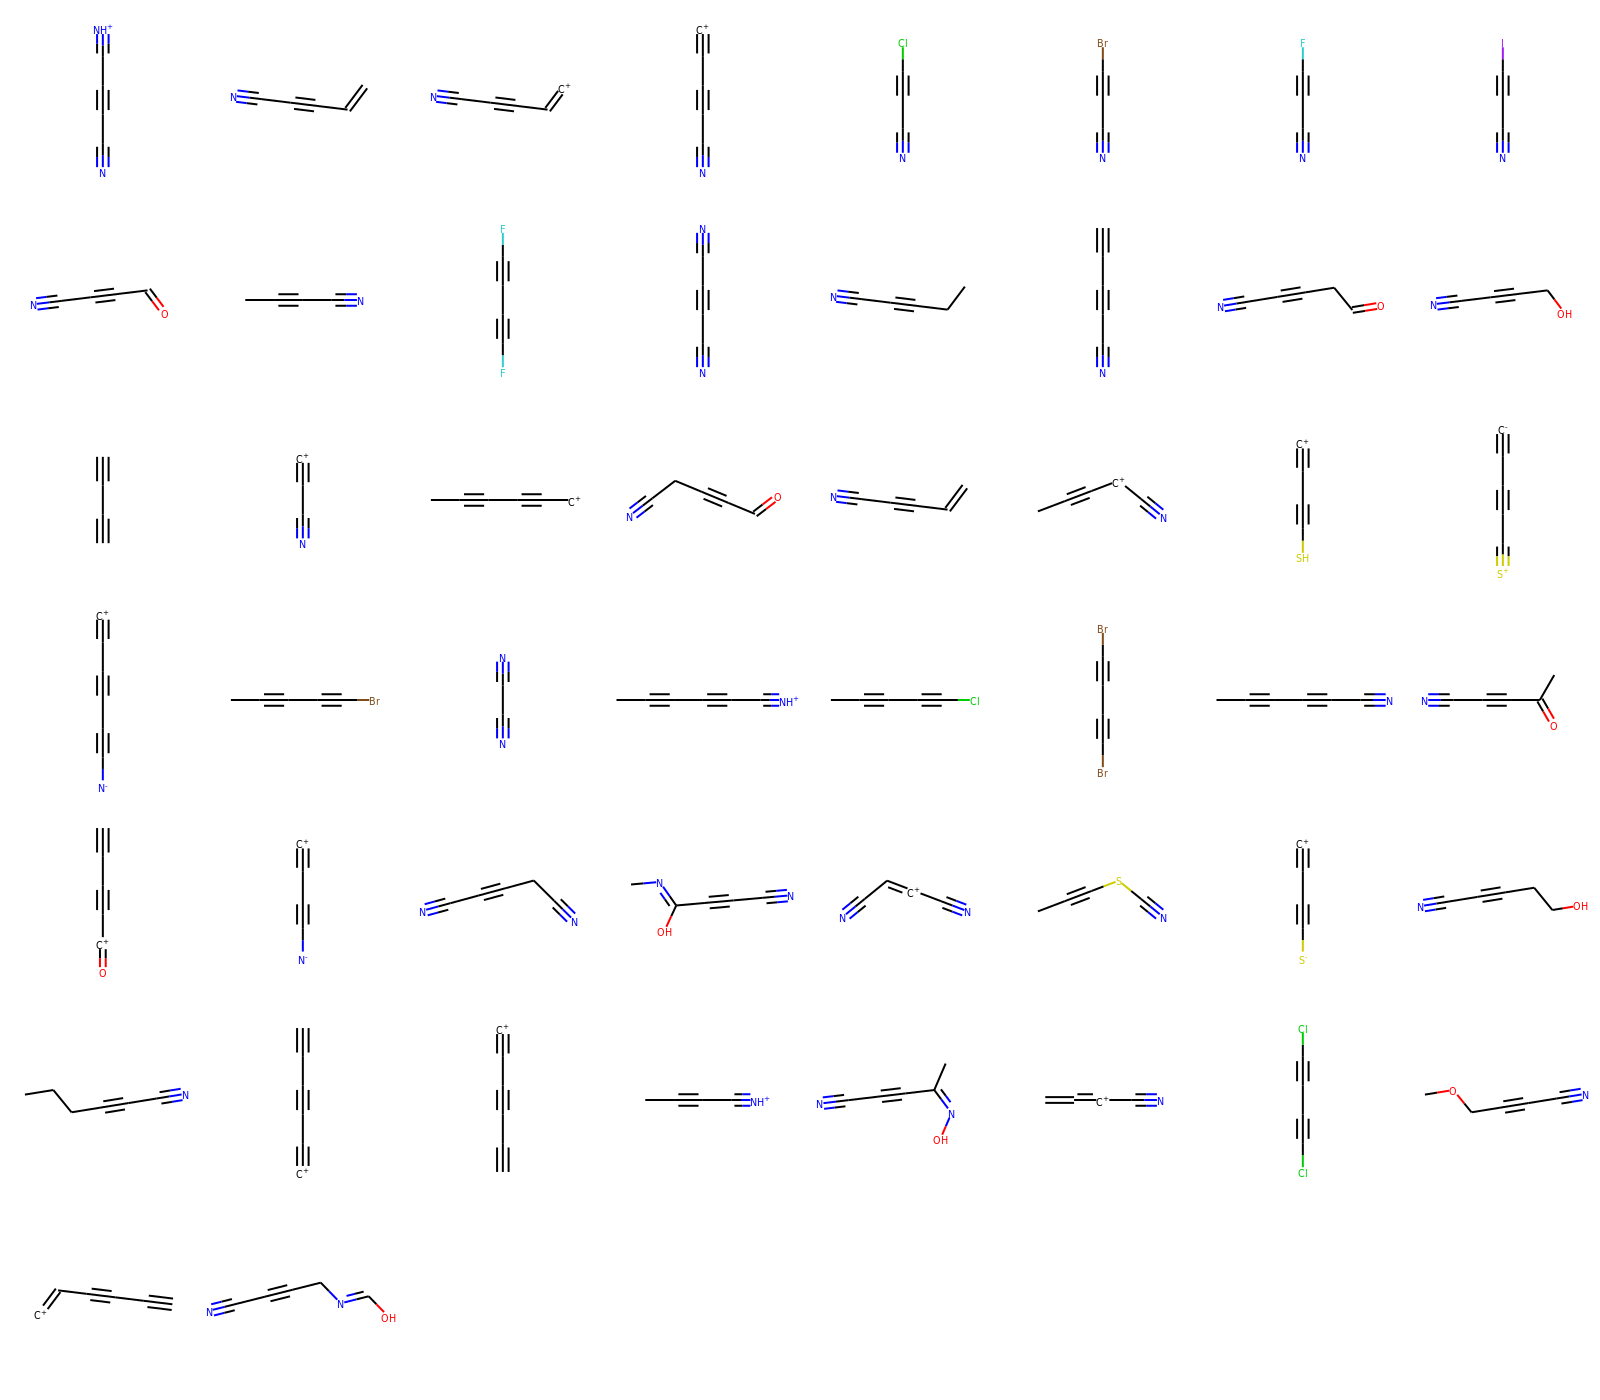

In [30]:
Chem.Draw.MolsToGridImage(mols, molsPerRow=8)

Let's try two other recently detected molecules

In [16]:
uno_cpd_smi = "C1C=CC=C1C#N"
dos_cpd_smi = "C1C=CC(=C1)C#N"

uno_cpd = embedder.vectorize(uno_cpd_smi)
dos_cpd = embedder.vectorize(dos_cpd_smi)

In [17]:
# we don't really care about the distance values, just the index
distances = pairwise_distances(vectors, uno_cpd[None,:]).ravel().compute()
sorted_indices = np.argsort(distances)
top_ten = sorted_indices[:100]

In [18]:
mols = [
    Chem.MolFromSmiles(smi) for smi in dataset.iloc[top_ten].head(50)["Raw"]
]

We can be as systematic as simply going through these and ticking them off one by one.

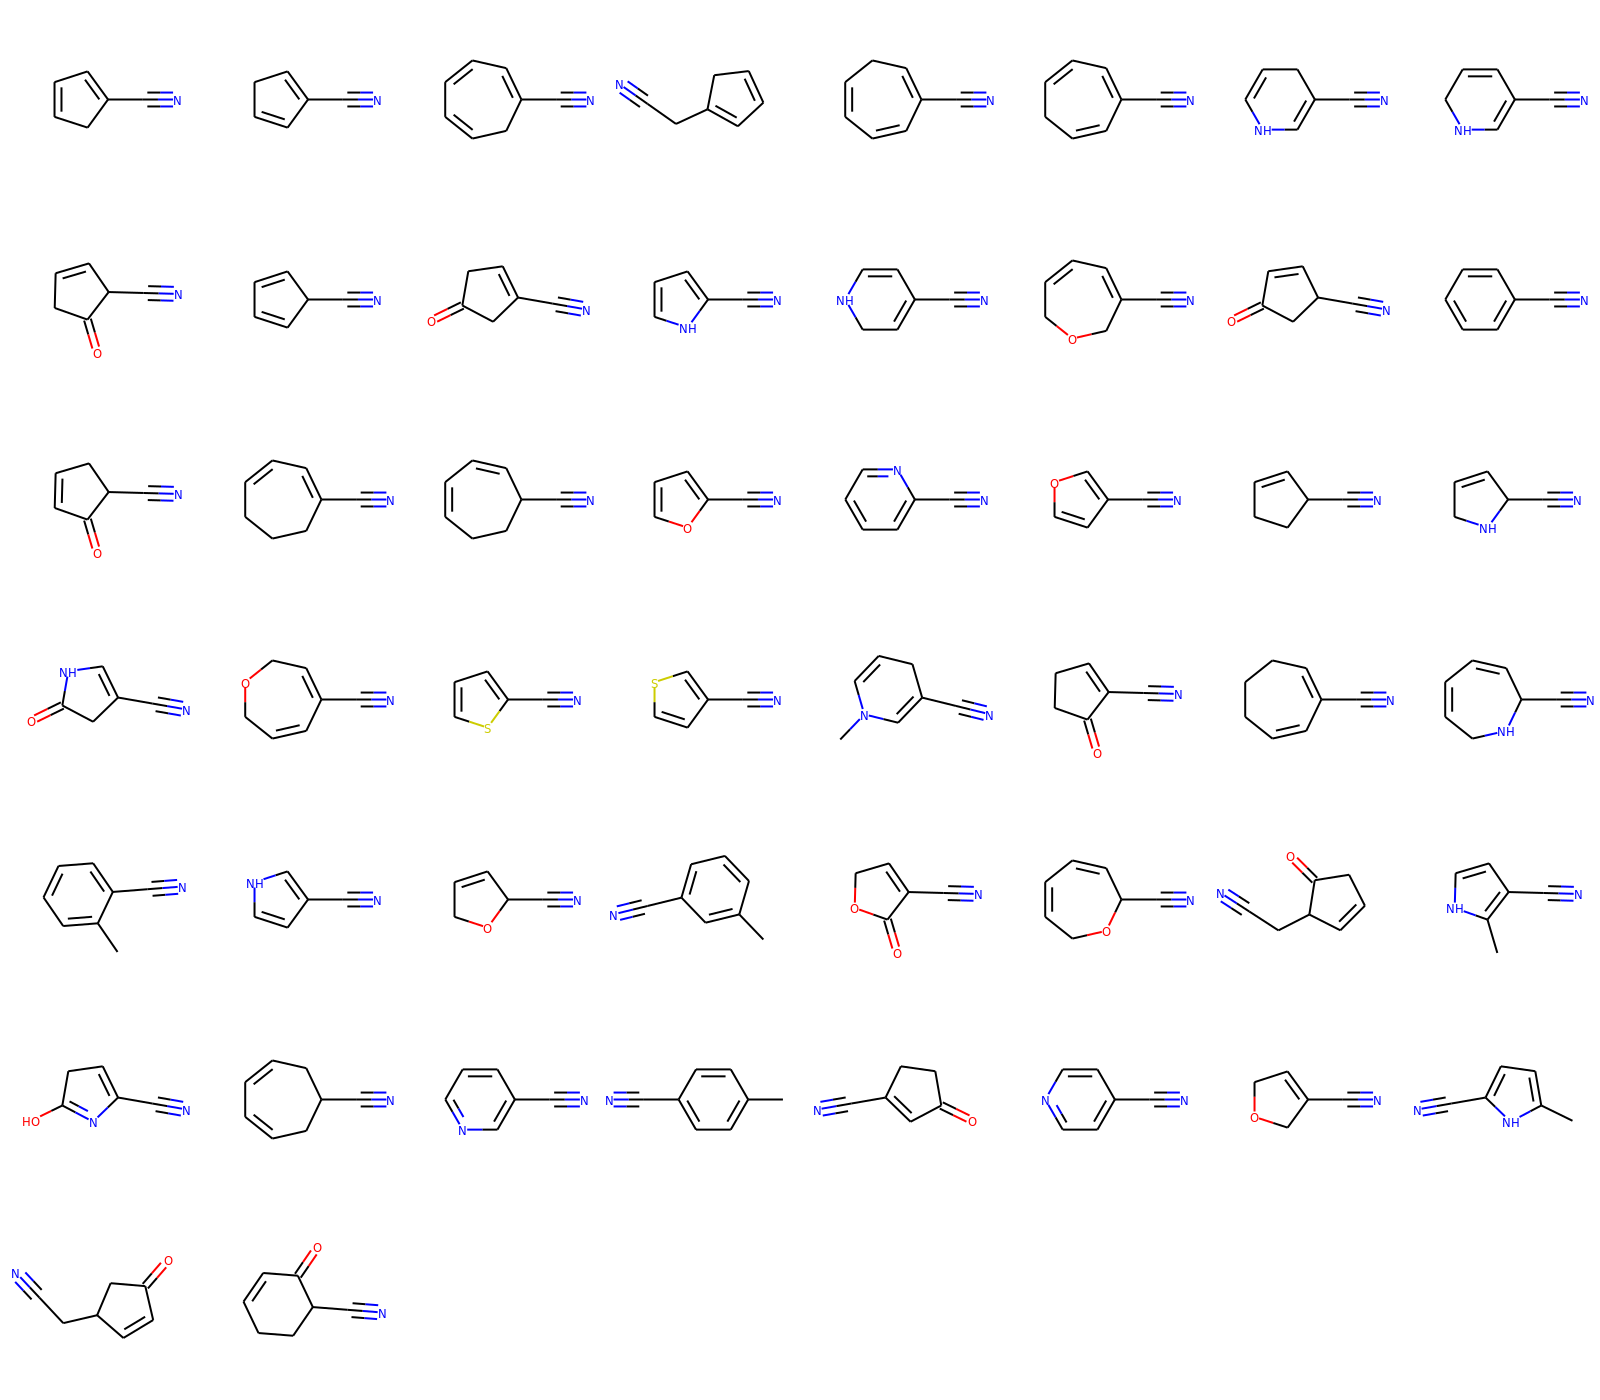

In [24]:
Chem.Draw.MolsToGridImage(mols, molsPerRow=8)

## Estimating properties

Our estimator/approximating function can be as simple as linear regression, or potentially a heavily regularized neural network for even more flexibility. We'll discuss Gaussian processes for column densities, and gradient boosting for rate coeffcients; these two methods are the most powerful - expressive, flexible - in terms of non-parametric modeling.

In [19]:
ncol_gp = load("../../models/gpr_grid.pkl").best_estimator_

/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [93]:
ncol_gp.predict(
    np.vstack(
        [
            benzonitrile, 
            benzene,
            glycine,
            caa,
            corannulene,
        ]
    ), 
    return_std=True
)

(array([11.36640871, 11.5260859 , 11.80903636,  9.99095639,  7.51105644]),
 array([1.44908661, 1.45741162, 1.32374387, 1.60826236, 2.49965071]))

In [22]:
columns, std = ncol_gp.predict(
    vectors[top_ten],
    return_std=True
)

In [24]:
std

array([1.40070596, 1.39979029, 1.49798392, 1.4202368 , 1.49064903,
       1.4937328 , 1.46811262, 1.45882511, 1.44390923, 1.40064694,
       1.46349628, 1.40655835, 1.46626403, 1.5064374 , 1.44003518,
       1.44908662, 1.45819019, 1.51375494, 1.49968509, 1.39405572,
       1.43188665, 1.38767392, 1.42452862, 1.42670028, 1.45584948,
       1.51185661, 1.38125098, 1.38469638, 1.51457301, 1.47059353,
       1.52499373, 1.50615423, 1.48909305, 1.41584688, 1.43216119,
       1.48776992, 1.45994525, 1.509315  , 1.47052689, 1.44550391,
       1.4570951 , 1.51364694, 1.42549465, 1.48921554, 1.47513507,
       1.42485796, 1.44634654, 1.46657207, 1.47720746, 1.50708796,
       1.45371953, 1.50099567, 1.46836936, 1.49330954, 1.48421695,
       1.45424025, 1.48307147, 1.50469501, 1.49375509, 1.48704135,
       1.45421263, 1.53695648, 1.47806206, 1.48857197, 1.49850737,
       1.48667052, 1.4635118 , 1.47066098, 1.47066098, 1.49659947,
       1.50299079, 1.45587502, 1.44564278, 1.50162252, 1.48210

For rates, this is not so straight forward, and likely a non-parametric method will not be good enough to model it well.

In [178]:
rate_gp = load("../../models/rate_gp_pipeline.pkl").steps[1][1]

/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [181]:
X = np.vstack([np.hstack([cn, benzene, T]) for T in np.linspace(2., 300., 100)])
T = np.linspace(2., 300., 100)

### Making the TMC-1 recommendations

In [31]:
tmc1_df = pd.read_pickle("../../data/interim/tmc1_table_vecs.pkl")

In [35]:
from umda.smi_vec import canonicize_smi

In [146]:
canonical_tmc1 = [canonicize_smi(smi) for smi in tmc1_df["SMILES"].to_list()]

In [49]:
tmc1_vecs = np.vstack([embedder.vectorize(smi) for smi in tmc1_df["SMILES"].to_list()])

In [54]:
suggestions = list()
for vector in tmc1_vecs:
    # we don't really care about the distance values, just the index
    distances = pairwise_distances(vectors, vector[None,:]).ravel().compute()
    sorted_indices = np.argsort(distances)
    top_ten = sorted_indices[:100]
    suggestions.extend([
        smi for smi in dataset.iloc[top_ten].head(50)["Raw"]
    ])

In [57]:
suggestions = list(set(suggestions))

In [59]:
mols = [Chem.MolFromSmiles(smi) for smi in suggestions]

In [166]:
valid_indices = [mol is not None for mol in mols]

In [215]:
valid_molecules = list()
for mol, smi in zip(mols, suggestions):
    if mol:
        if ExactMolWt(mol) > 20. and MaxAbsPartialCharge(mol) < 1.:
            valid_molecules.append(smi)

In [216]:
ignore = ["Br", "B", "F", "Nb", "Er", "Ga", "La", "F", "Eu", "Mg", "Bi", "Ru", "Cr", "Ti", "Th", "Md", "Se", "Os", 
          "Ge", "Pd", "Pr", "Pb", "W", "Gd", "Np", "Pt", "Cl" "Rh", "Es", "Sm", "Ac", "Te", "Hf", "I", "Nd", "Sr", "Ir",
          "Lu", "Tc", "Yb", "Rn", "Sb", "As", "Rh", "Cd", "Tl", "Cs", "Al", "Y", "Dy", "R", "A", "Mo", "K", "Sc", "Tb",
          "Zn", "Cu", "Na", "Co", "Cm", ".", "Pa", "Pm", "Sn", "Lr", "Pu", "Cf", "[2H]N=CO"
         ] 

In [217]:
filtered_suggestions = list(filter(lambda x: not any([test in x for test in ignore]), valid_molecules))

In [218]:
notinlist = list(filter(lambda x: x not in canonical_tmc1, filtered_suggestions))

In [219]:
longenough = list(filter(lambda x: len(x) > 3, notinlist))

In [220]:
# for index, chunk in enumerate(np.array_split(np.array(longenough), 40)):
with open(f"targets.smi", "w+") as write_file:
    for smi in longenough:
        write_file.write(f"{smi}\n")